In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import math
import time
import scipy.stats as stats
from scipy.stats import zscore 

from collections import defaultdict
from scipy.stats.stats import pearsonr

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot

CUSTOMER_SUPERMARKET = "../dataset/customer_supermarket.csv"
SALE_QTA_MERGE = "../dataset/customer_supermarket_sale_qta_merge.csv"
INCONSISTENT_PROD = '../dataset/inconsistent_ProdID_ProdDescr.json'
INCONSISTENT_COUNTRY = '../dataset/inconsistent_CustomerID_CustomerCountry.json'
FINAL_UNDERSTANDING = "../dataset/customer_supermarket_understanding.csv"

NO_INCONSISTENCY = "../dataset/customer_supermarket_no_inconsistency.csv"
INDICATORS = "../dataset/indicators.csv"
INDICATORS_NO_OUTLIER = "../dataset/indicators_no_outlier.csv"
NO_OUTLIER = "../dataset/customer_supermarket_no_outlier.csv"

## Loading the dataset

In [2]:
df = pd.read_csv(CUSTOMER_SUPERMARKET, sep="\t", index_col=0, parse_dates=["BasketDate"], decimal=",")

## Attributes and check

In [3]:
df.dtypes

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                 object
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
dtype: object

In [4]:
df.isna().any()

BasketID           False
BasketDate         False
Sale               False
CustomerID          True
CustomerCountry    False
ProdID             False
ProdDescr           True
Qta                False
dtype: bool

Here we can have an idea of data types we are going to use

| Attribute       | Type       |
|-----------------|------------|
| BasketID        | int64      |
| BasketDate      | datetime64 |
| Sale            | float64    |
| CustomerID      | int64      |
| CustomerCountry | object     |
| ProdID          | object     |
| ProdDescr       | object     |
| Qta             | int64      |

as we can see there are problems in the attribute values, so we have to evaluate what prevents us from getting the desired data types:

The execution df['BasketID'].astype(int) tell us that some rows contains literal inside the attribute BasketID, this means the data type cannot be converted to int

## Checking NaN values and duplicates

It is possible to evaluate the quality of the data from the point of view of the rows, based on two aspects:
- missing or partial value (NaN/Null values)
- duplicates
- duplicates products in the same basket

Any duplicates or rows with missing values are temporarily removed from the dataset to allow for better evaluation

In [5]:
# check if there are duplicates
areduplicates = df.duplicated().any()

# duplicates have been removed from the data set
df_nodup = df.drop_duplicates()

# check if there are missing or incomplete values
arenan = df.isnull().values.any()

# rows with missing or incomplete values have been removed from the data set
df_clean = df_nodup.dropna()

print("Duplicate rows in the dataset: ", areduplicates, "| Number or rows removed: ", len(df)-len(df_nodup))
print("NaN/Null values in the dataset: ", arenan, "| Number or rows removed: ", len(df_nodup)-len(df_clean))

df_Sale_Qta_merge = df_clean.groupby(['BasketID','BasketDate','ProdID']).agg({'Qta':np.sum,
                                                                         'Sale':np.sum,
                                                                         'CustomerID':'min',
                                                                         'CustomerCountry':'min',
                                                                         'ProdDescr':'min'}).reset_index()

df_Sale_Qta_merge.to_csv(SALE_QTA_MERGE, sep="\t", decimal=",", index=False)

print(f"Number of identical items in multiple rows of the same receipt {len(df_clean) - len(df_Sale_Qta_merge)}")

df = df_Sale_Qta_merge

Duplicate rows in the dataset:  True | Number or rows removed:  5232
NaN/Null values in the dataset:  True | Number or rows removed:  65073


KeyboardInterrupt: 

## Checking data consistency

Here we are verifing that the dataset is consistent:

1. Every ProdID must match the same ProdDescr
2. Every CustomerID must match the same BasketID in the same BasketDate
3. Every CustomerID must match the same CustomerCountry

In [ ]:
def inconsistent_set(K,V):
    
    inconsistentset = list()

    for key in tqdm(df[K].unique().tolist()):
        temp_df = df[df[K] == key]
        valueslist = temp_df[V].tolist()
        for value in valueslist:
            if(valueslist[0] != value):
                inconsistentset.append(key)
                break;
    return inconsistentset


# 1
ProdID_ProdDescr_IS = inconsistent_set("ProdID","ProdDescr")
            
print("Number of not consistent ProdDescr:", len(ProdID_ProdDescr_IS))

with open(INCONSISTENT_PROD, 'w') as f:
    json.dump(ProdID_ProdDescr_IS, f, sort_keys=True)


#2 True == no error
temp = df.groupby(['BasketID','BasketDate']).CustomerID.nunique().eq(1)
print("Every CustomerID matches the same BasketID in the same BasketDate: ", temp.all())

#to avoid graphical printing bug
time.sleep(0.1)
#3 
CustomerID_CustomerCountry_IS = inconsistent_set("CustomerID","CustomerCountry")
            
print("Number of not consistent CustomerCountry:", len(CustomerID_CustomerCountry_IS))


with open(INCONSISTENT_COUNTRY, 'w') as f:
    json.dump(CustomerID_CustomerCountry_IS, f, sort_keys=True)

## Converting attributes to correct data type

Here we are changing the type of attributes. This imply a little cleaning phase over BasketID because there are characters inside the values

In [ ]:
#df = pd.read_csv(SALE_QTA_MERGE, sep="\t", index_col=0, parse_dates=["BasketDate"], decimal=",")

df['CustomerID'] = pd.to_numeric(df.CustomerID)
df.CustomerID = df.CustomerID.astype(int)

## Statistics and data understanding

Here are informations about quantities

In [ ]:
print("Number of clients: ",len(df['CustomerID'].unique()))
print("Number of products: ",len(df['ProdID'].unique()))
print("Number of purchase: ",len(df['BasketID'].unique()))
print("Distinct Customer Country: \t", len(df.CustomerCountry.unique()))

# number of items cancelled in the basket by every customer
basket_cancelled = df[df['BasketID'].str.contains("C")]
print("Number or rows with cancelled items: ", len(basket_cancelled))

#print("Distinct values in ProdID: \t", df_clean.ProdID.unique())
#print("Distinct values in ProdDescr: \t", df_clean.ProdDescr.unique())

We have people coming from unspecified countries, a generic "European Community", EIRE which stands for Ireland and RSA which stands for Republic of South Africa.

In [ ]:
print("Number of customers from Unspecified countries: \t", (df.CustomerCountry == "Unspecified").sum())
print("Number of customers from generic European Community countries: \t", (df.CustomerCountry == "European Community").sum())

In [ ]:
df.describe()

In [ ]:
df.to_csv(FINAL_UNDERSTANDING, index=False)

## Data cleaning

The following cells will improve the DF, which presents inconsistency, missing values and outliers, thanks to consideration done during the data understanding phase

In [ ]:
df = pd.read_csv(FINAL_UNDERSTANDING, parse_dates=["BasketDate"], decimal=",")
df.Sale = df.Sale.astype(float)

For every canceled basket ('C'+'BasketID') check if exists at least one counterpart

In [ ]:
df_check = df[(df['BasketID'].str.contains('C')) & (df['ProdID'] != 'D')][['CustomerID','Qta','ProdID']]
for index, col in  df_check.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Qta'] == -col[1]) & (df['ProdID'] == col[2])].shape[0] == 0: 
        print(True)
        break

Remove from the dataset the rows with canceled basket and possible counterpart (if there are more then one counterpart, the first will be deleted)

In [ ]:
df_temp = df[(df['BasketID'].str.contains('C')) & (df['ProdID'] != 'D')]

rows_with_counterparts = []
rows_without_counterparts = []

for index, col in df_temp.iterrows():
    df_temp = df[(df['CustomerID'] == col['CustomerID']) & (df['Qta'] == -col['Qta']) & (df['ProdID'] == col['ProdID'])]
    
    if df_temp.shape[0] == 0: 
        rows_without_counterparts.append(index)
    else:
        rows_with_counterparts.append(index)
        rows_with_counterparts.append(df_temp.index[0])
    
rows_to_be_dropped = rows_with_counterparts + rows_without_counterparts

df_canceled_basket = df.drop(df.index[rows_to_be_dropped])

print("Total number of dropped rows: ", len(df)-len(df_canceled_basket))

df = df_canceled_basket

In [ ]:
# inconsistency resolution

def inconsistency_resolver(path,col1,col2):
    
    with open(path, 'r') as f:
        inconsistent_list = json.load(f)
        
    df_inconsistent = df[df[col1].isin(inconsistent_list)]

    df_grouped = df_inconsistent.groupby([col1,col2]).size().reset_index()
    
    df_grouped = df_grouped.sort_values(0, ascending=False).drop_duplicates(col1).sort_index()
    
    mydict = pd.Series(df_grouped[col2].values,index=df_grouped[col1]).to_dict()
    
    for k,v in mydict.items():
        
        df.loc[df[col1] == k, col2] = v

inconsistency_resolver(INCONSISTENT_COUNTRY,"CustomerID","CustomerCountry") 
inconsistency_resolver(INCONSISTENT_PROD,"ProdID","ProdDescr") 

In [ ]:
''' check if inconsistency has been solved
# 1
ProdID_ProdDescr_IS = inconsistent_set("ProdID","ProdDescr")
            
print("Number of not consistent ProdDescr:", len(ProdID_ProdDescr_IS))

#3 
CustomerID_CustomerCountry_IS = inconsistent_set("CustomerID","CustomerCountry")
            
print("Number of not consistent CustomerCountry:", len(CustomerID_CustomerCountry_IS))
'''

DF without inconsistency serialization

In [ ]:
df.to_csv(NO_INCONSISTENCY, sep="\t", decimal=",", index=False)

## Indicators

In [ ]:
df = pd.read_csv(NO_INCONSISTENCY, sep="\t", parse_dates=["BasketDate"], decimal=",")
print(df.head())
print(df.info())

# I - indicator
the total number of items purchased by a customer during the period of
observation.

In [ ]:
df_i = df.groupby("CustomerID").sum().reset_index()
df_i = df_i[["CustomerID", "Qta"]]
df_i

# Iu - indicator
the number of distinct items bought by a customer in the period of
observation.

In [ ]:
df_iu = df.groupby('CustomerID')['ProdID'].nunique().reset_index()
df_iu

# Imax - indicator
the maximum number of items purchased by a customer during a
shopping session

In [ ]:
df_imax = df.groupby(["CustomerID", "BasketID"]).Qta.sum()
df_imax = df_imax.groupby(level=0).head(1).reset_index()

#df_imax = df_imax.max(level=0)

df_imax

# E - indicator
the Shannon entropy on the purchasing behaviour of the customer

In [ ]:
# Entropy helper function 
import numpy as np
from scipy.stats import entropy
from math import log, e
import pandas as pd   

""" Usage: pandas_entropy(df['column1']) """

def pandas_entropy(column, base=None):
    vc = pd.Series(column).value_counts(normalize=True, sort=False)
    base = e if base is None else base
    return -(vc * np.log(vc)/np.log(base)).sum()

In [ ]:
df_temp = df.groupby(["CustomerID", "BasketID"]).Qta.sum().reset_index()
df_entropy = pd.DataFrame(df.CustomerID.unique(), columns=["CustomerID"])

entropies = []

for customer in df_temp.CustomerID.unique():
    customer_baskets = df_temp[df_temp.CustomerID == customer]
    entropies.append(pandas_entropy(customer_baskets["Qta"]))
    #print(df_temp[df_temp.CustomerID == customer])
    
df_entropy["Entropy"] = entropies

# Additional indicators

### Total Spending
We compute the total amount spent by each customer in the observation period

In [ ]:
df_tot = df.groupby(["CustomerID"]).Sale.sum()
df_tot = df_tot.groupby(level=0).head(1).reset_index()

print(df_tot)

### Average spending
We compute the average basket value for each user

In [ ]:
df_customer_basket_groupby_sum = df.groupby(["CustomerID",'BasketID'], as_index=False).agg({"Sale":sum})
df_mean = df_customer_basket_groupby_sum.groupby('CustomerID')['Sale'].mean()
df_mean = df_mean.groupby(level=0).head(1).reset_index()

print(df_mean)

### Discounts per user
We count the number of times a customer used a discount

In [ ]:
df_discounts = df[df['ProdDescr'] == "Discount"]['CustomerID'].value_counts()

### Putting together all indicators

In [ ]:
print(df_tot.Sale)

In [ ]:
df_indicators = pd.DataFrame(df.CustomerID.unique(), columns=["CustomerID"]).sort_values(by=['CustomerID'])
df_indicators["Entropy"] = df_entropy.Entropy.values
df_indicators["i"] = df_i.Qta.values
df_indicators["iu"] = df_iu.ProdID.values
df_indicators["imax"] = df_imax.Qta.values
df_indicators["tot_sales"] = df_tot.Sale.values
df_indicators["mean_sales"] = df_mean.Sale.values

df_indicators.to_csv(INDICATORS, index=False)
print(df_indicators)

## Indicators box plots

In [ ]:
def boxplots(dataframe):
    fig = make_subplots(
        rows=1, cols=5,
        subplot_titles=("i", "iu", "imax", "tot_sales", "mean_sales")
    )

    fig.add_trace(
        go.Box(y=dataframe['i']),
        row=1,col=1
    )
    fig.add_trace(
        go.Box(y=dataframe['iu']),
        row=1,col=2
    )
    fig.add_trace(
        go.Box(y=dataframe['imax']),
        row=1,col=3
    )
    fig.add_trace(
        go.Box(y=dataframe['tot_sales']),
        row=1,col=4
    )
    fig.add_trace(
        go.Box(y=dataframe['mean_sales']),
        row=1,col=5
    )

    fig.update_layout(height=600)
    fig.show()
    
boxplots(df_indicators)

## Outlier removal

In [ ]:
z_scores = stats.zscore(df_indicators)

abs_z_scores = np.abs(z_scores)

filtered_entries = (abs_z_scores < 3).all(axis=1)

df_indicators_no_outlier = df_indicators[filtered_entries]

In [ ]:
boxplots(df_indicators_no_outlier)

### Serializing indicators without outliers and DF without outliers

In [ ]:
df_indicators_no_outlier.to_csv(INDICATORS_NO_OUTLIER, index=False)

df_no_outlier = df.loc[df['CustomerID'].isin(df_indicators_no_outlier['CustomerID'].unique().tolist())]
df_no_outlier.to_csv(NO_OUTLIER, index=False)

## Distributions

### Grid of plots

In [ ]:
#df = px.data.tips()

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=("i","iu","imax","tot_sales","mean_sales")
)


# amount spent by customer distribution 
fig.add_trace(
    go.Histogram(x=df_indicators_no_outlier['i'].tolist()),
    row=1, col=1
)


# amount spent by customer distribution 
fig.add_trace(
    go.Histogram(x=df_indicators_no_outlier['iu'].tolist()),
    row=1, col=2
)


# amount spent by customer distribution 
fig.add_trace(
    go.Histogram(x=df_indicators_no_outlier['imax'].tolist()),
    row=1, col=3
)


# amount spent by customer distribution 
fig.add_trace(
    go.Histogram(x=df_indicators_no_outlier['tot_sales'].tolist()),
    row=2, col=1
)


# amount spent by customer distribution 
fig.add_trace(
    go.Histogram(x=df_indicators_no_outlier['mean_sales'].tolist()),
    row=2, col=2
)


fig.update_layout(height=1000, width=1200, title_text="Distributions")
fig.show()

In [ ]:
temp = df[['CustomerID', 'CustomerCountry']].groupby(['CustomerID', 'CustomerCountry']).count()
temp = temp.reset_index(drop = False)
countries = temp['CustomerCountry'].value_counts()
data = dict(type='choropleth',
    locations = countries.index,
    locationmode = 'country names', z = countries,
    text = countries.index, colorbar = {'title':'Order nb.'},
    colorscale=[[0, 'rgb(224,255,255)'],
                [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
                [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
                [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
                [1, 'rgb(227,26,28)']],    
    reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',height=1000, width=1200,
    geo = dict(showframe = True, projection={'type':'mercator'})
            )
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

### Amount of qta per month and sum of income per month during the observation date

In [ ]:
df_temp = df.set_index("BasketDate").copy()
monthly_qta = df_temp.groupby(pd.Grouper(freq='M'))["Qta"].sum()
monthly_sales = df_temp.groupby(pd.Grouper(freq='M'))["Sale"].sum()

#print(monthly_sales)
'''
print(monthly_receipt)
print(monthly_qta)
print(monthly_sales)

plt.figure(figsize=(16,5))
plt.plot(monthly_receipt.index, monthly_qta, color='tab:blue', marker="o")
plt.plot(monthly_qta.index, monthly_qta, color='tab:red', marker="x")
plt.plot(monthly_sales.index, monthly_sales, color='tab:green', marker="*")
'''
month_list = monthly_qta.keys().to_list()
monthly_qta_list = monthly_qta.to_list()
monthly_sales_list = monthly_sales.to_list()

fig = go.Figure()

fig.add_trace(go.Scatter(x=month_list, y=monthly_sales_list,
                    mode='lines+markers',
                    name='monthly_sales_list'))

fig.add_trace(go.Scatter(x=month_list, y=monthly_qta_list,
                    mode='lines+markers',
                    name='monthly_qta_list'))


fig.show()

### The average cost of a basket

In [ ]:
df_customer_basket_groupby_sum = df.groupby(["CustomerID",'BasketID'], as_index=False).agg({"Sale":sum})

series_customer_basket_groupby_mean = df_customer_basket_groupby_sum.groupby('CustomerID')['Sale'].mean()
df_customer_basket_groupby_mean = pd.DataFrame(df_customer_basket_groupby_mean)

binwidth = 50
bins=range(0, 400 + binwidth, binwidth)
print(bins)
n, bins, patches = plt.hist(df_customer_basket_groupby_mean.Sale, bins=bins, facecolor='blue', alpha=0.5)
plt.savefig('../output/total_receipt_price_distribution.png')
plt.show()

basket_cost_profile = pd.cut(df_customer_basket_groupby_mean['Sale'], bins=[0, 50, 200, df_customer_basket_groupby_mean.Sale.max()], include_lowest=True, labels=["low", "medium", "high"])
basket_cost_profile

### Sales per country

In [ ]:
df_sales_per_country = df.groupby(["CustomerCountry"])["Sale"].sum().reset_index()
print(df_sales_per_country)

In [ ]:
# the pie plot is horrible because of england, that probably has some outliers
#explode=np.zeros(len(df_sales_per_country.CustomerCountry))

plt.pie(df_sales_per_country.Sale, labels=df_sales_per_country.CustomerCountry, autopct='%1.1f%%')
plt.show()

### Most bought items

In [ ]:
cols_dropped = [2, 3, 6]
df_most_bought = df.groupby(["ProdID", "ProdDescr"]).sum().reset_index()
#df_most_bought = df_most_bought.drop(df_most_bought.columns[cols_dropped], axis=1)
df_most_bought = df_most_bought.sort_values(by="Qta", ascending=False)
#df_most_bought = df_most_bought.groupby(level=0).head(1).reset_index()
df_most_bought 

#print(df[df.ProdDescr == "Discount"])

In [ ]:
plt.pie(df_most_bought[:10].Qta, labels=df_most_bought[:10].ProdDescr, autopct='%1.1f%%')
plt.savefig("../output/most_bought_item_piechart.png")
plt.show()

### Most bought item per country


In [ ]:
#cols_dropped = [3, 4, 7]
df_mb_country = df.groupby(["ProdID", "ProdDescr", "CustomerCountry"]).sum().reset_index()
df_mb_country = df_mb_country.drop(["Sale"], axis = 1)

df_mb_country = df_mb_country[df_mb_country.groupby(["CustomerCountry"])["Qta"].transform("max") == df_mb_country["Qta"]].reset_index()

#df_mb_country = df_mb_country.groupby(["CustomerCountry"]).agg({"Qta" : "max"}).reset_index()
#print(df_mb_country.CustomerCountry.unique())


print(df_mb_country)


## Correlation

In [9]:
df = pd.read_csv(INDICATORS_NO_OUTLIER).drop("CustomerID", axis=1)

### Correlation matrix

There seems to be absolutely no correlation between the values of the dataset

In [10]:
correlations = df.corr(method="pearson")
correlations

,Entropy,i,iu,imax,tot_sales,mean_sales
Entropy,1.000000,0.667859,0.648117,0.072349,0.702030,-0.039672
i,0.667859,1.000000,0.554462,0.402551,0.610791,0.026794
iu,0.648117,0.554462,1.000000,0.227949,0.865038,0.481600
imax,0.072349,0.402551,0.227949,1.000000,0.140727,0.213042
tot_sales,0.702030,0.610791,0.865038,0.140727,1.000000,0.423709
mean_sales,-0.039672,0.026794,0.481600,0.213042,0.423709,1.000000


<AxesSubplot:>

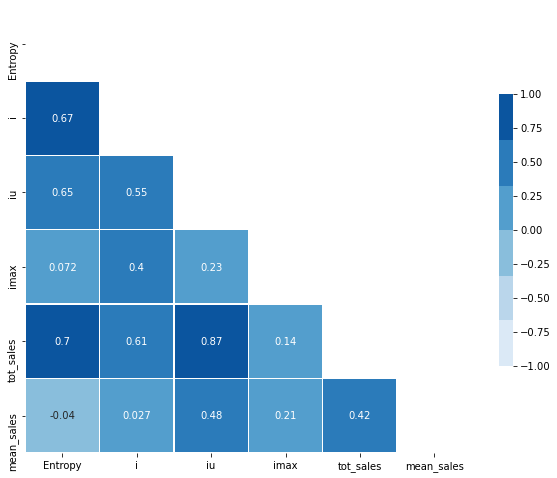

In [11]:
import seaborn as sns

mask = np.triu(np.ones_like(correlations, dtype=bool))

# this diverging palette is pretty dull since everything is unrelated
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.color_palette("Blues")
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})

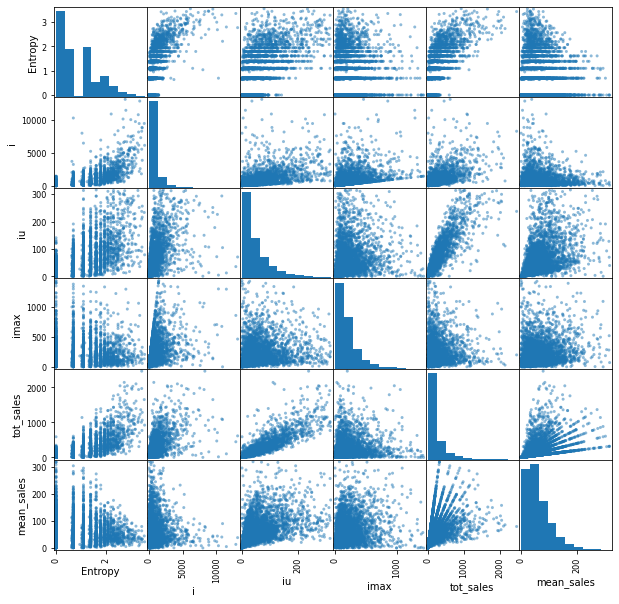

In [12]:
pd.plotting.scatter_matrix(df,figsize=(10,10))
plt.show()